## Imports
All the necessary libraries
- tensorflow (tf)
    - a machine learning framework
- PIL (Python Image Library) 
    - to look at images easily
- Numpy (np)
    - convert images to matrices and other math functions
- keras
    - high level API to interface with tf and perform ML tasks
- Matplotlib
    - to plot relevant data and show images
- Technically Jupyter Notebook
    - enabled live scripting for easy coding and testing


data:
https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


In [92]:
from PIL import Image
import tensorflow as tf
from keras import Sequential, layers
import keras
import os
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A


## Preproccessing

convert all images to 224px x 224px
using keras we split the data into a training dataset and validating dataset
**this is important as we can not test on data we trained the model with**

The bottom code is just to show the images while I was writing the code


Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


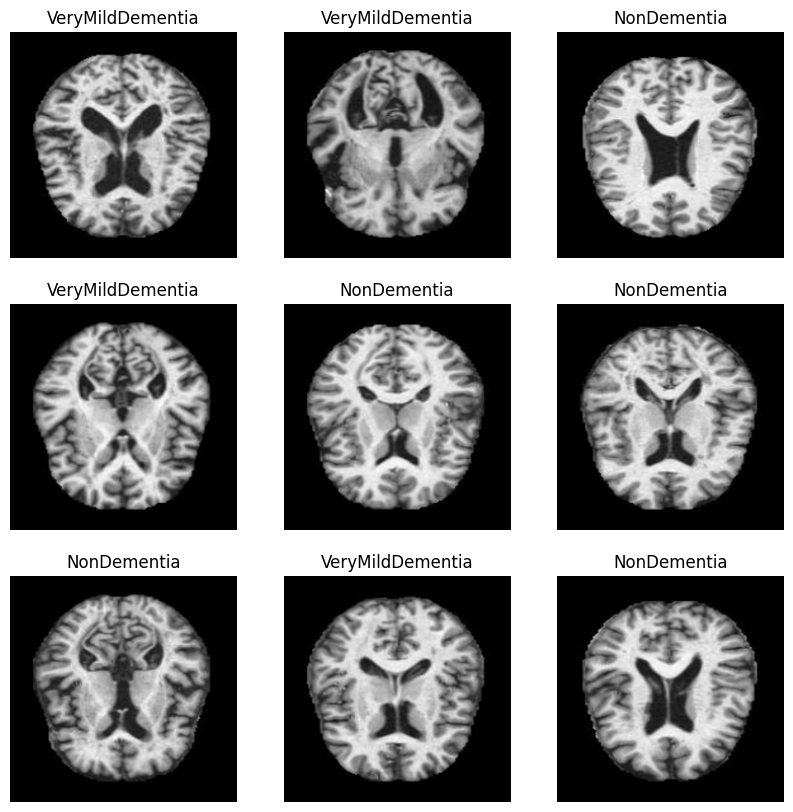

In [93]:
img_size = (224,224)

train_ds = keras.utils.image_dataset_from_directory(
    directory='Alzheimer_s Dataset/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=img_size)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='Alzheimer_s Dataset/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=img_size)

# batch_1=train_ds.take(1)

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
validation_ds.class_names = class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[list(labels[i].numpy()).index(1)])
    plt.axis("off")

In [94]:
We normalize the data to 0-1 from 0-255

SyntaxError: invalid syntax (91554582.py, line 1)

In [ ]:
class_names = train_ds.class_names
print(class_names)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


## Data augmentation

252
252
253
251


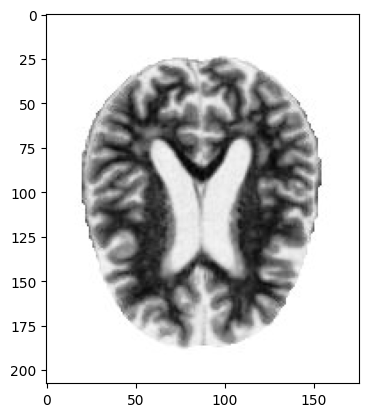

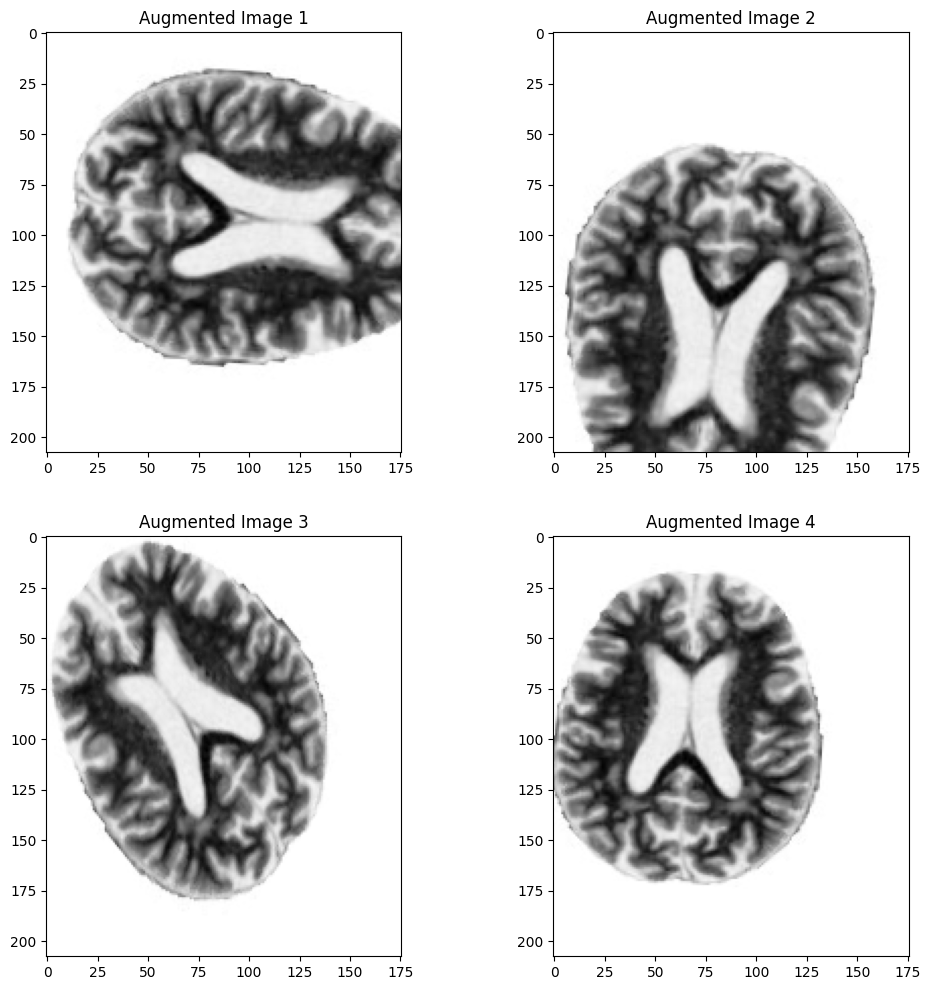

In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_path = "C:\\Users\\yugio\\School\\Sophmore\\BME240\\BME240_ML\\Alzheimer_s Dataset\\test\\MildDemented\\26.jpg"  # Replace with your image path
image = Image.open(image_path)
plt.imshow(image,cmap='Greys')

image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)  # Add batch dimension

# Define an augmentation pipeline
datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

augmented_images = []
num_augmented_images = 4  # Number of augmented images to generate

for i, batch in enumerate(datagen.flow(image_array, batch_size=1)):
    augmented_images.append(tf.squeeze(batch, axis=0))
    if i >= num_augmented_images - 1:
        break

# Display augmented images
plt.figure(figsize=(12, 12))
for i, augmented_image in enumerate(augmented_images):
    plt.subplot(2, 2, i + 1)
    plt.title(f'Augmented Image {i + 1}')
    aug_img = tf.cast(augmented_image, tf.uint8)
    plt.imshow(aug_img,cmap='Greys')
    print(aug_img.numpy().max())
    # plt.axis('off')



## Defining the Model

here we utilize MobileNet as a base architecture and use imagenet weights as a good starting point.

then we define a keras model which takes the 1000 classes from mobilenet and cuts it down to 4 which represent our 4 classes

input: resized images --- MobileNet w imagenet weights --> 1000 classes --- Dense layer --> our 4 classes

In [104]:
num_classes = len(class_names)

model_MN = tf.keras.applications.MobileNet(
    input_shape=None,
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
model_MN.trainable = False

model = keras.Sequential([
    # layers.Resizing(224, 224, input_shape=(176, 208, 3)),
    layers.Rescaling(1./255, input_shape=(224,224,3)),
    model_MN,
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.build(img_size)


here im just compiling the model

idk what adam optimization and loss is

In [105]:
model.compile(optimizer='adam',loss=tf.losses.BinaryCrossentropy(),
              # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [106]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_39 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenet_1.00_224 (Functi  (None, 1000)              4253864   
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 128)               128128    
                                                                 
 dense_13 (Dense)            (None, 4)                 516       
                                                                 
Total params: 4382508 (16.72 MB)
Trainable params: 128644 (502.52 KB)
Non-trainable params: 4253864 (16.23 MB)
_________________________________________________________________


epochs is how many times the model trains on every image in the training set

and then I fit the network to the training set

In [107]:
epochs=2
model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs                                                                                             
)
print("Evaluate on test data")
results = model.evaluate(validation_ds, batch_size=1)
print("test loss, test acc:", results)

Epoch 1/2
161/161 [==============================] - 169s 1s/step - loss: 0.5844 - accuracy: 0.4730 - val_loss: 0.4718 - val_accuracy: 0.5012
Epoch 2/2
161/161 [==============================] - 175s 1s/step - loss: 0.4684 - accuracy: 0.5015 - val_loss: 0.4713 - val_accuracy: 0.5020
Evaluate on test data
40/40 [==============================] - 35s 864ms/step - loss: 0.4713 - accuracy: 0.5020
test loss, test acc: [0.4713260233402252, 0.5019546747207642]


In [ ]:

img_path = "Alzheimer_s Dataset/test/ModerateDemented/27.jpg"
img = Image.open(img_path)
# img_size
img_resized = img.resize(img_size)
# np_img = np.asarray(img_resized)
img_resized.size


In [ ]:
predictions = model.predict(np.asarray(img_resized))